## Import dependent libraries

In [5]:
from pandas import read_csv
from matplotlib import pyplot
import math
from numpy import concatenate, array
from pandas import DataFrame
from pandas import concat
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Model, model_from_json
from keras.layers import Input
import keras
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers.recurrent import LSTM
from keras.utils import to_categorical
from keras.models import model_from_json
from keras.layers.core import Activation
from keras.callbacks import ReduceLROnPlateau
from keras.utils import plot_model
from sklearn.externals import joblib
import tensorflow as tf
from keras.utils import plot_model
import keras.backend as K


Using TensorFlow backend.


## Parameters

In [6]:
# specify the number of lag hours
n_hours = 128
n_features = 2
n_train_hours = 1000
n_divisions = 4
batch_size = 128
epochs = 100

## Load dataset

In [7]:
dataset = read_csv('music_data.csv', header=0)
values = dataset.values
values = values.astype('float32')

## Specify columns to plot

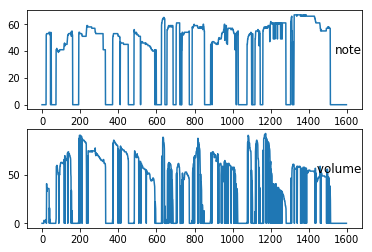

In [8]:
groups = [0, 1]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1


pyplot.show()

## Convert series to supervised learning

In [9]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [10]:
dataset = read_csv('music_data.csv', header=1)
values = dataset.values
values = values.astype('float32')

## Scale Data

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

joblib.dump(scaler, 'scaler.pkl')
print('Saved scaler to disk.')
# frame as supervised learning

Saved scaler to disk.


In [12]:
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
# print(reframed)

In [13]:
values = reframed.values
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features

In [14]:
train_X = train[:, :n_obs]
# print(train_X)

train_y_notes = train[:, -n_features]
train_y_volume = train[:, -n_features -1]
train_y_length = train[:, -n_features -2]

test_X = test[:, :n_obs]
# print(test_X)
test_y_notes = test[:, -n_features]
test_y_volume = test[:, -n_features -1]
test_y_length = test[:, -n_features -2]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
# print(train_X[0:10])

test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y_notes.shape, test_X.shape, test_y_notes.shape)

(1000, 128, 2) (1000,) (469, 128, 2) (469,)


In [15]:
params = {'num': 0}
setattr(K, 'params', params)

In [28]:
branch_input_size = int(n_hours)
branch_output_size = int(n_hours/n_divisions/n_divisions)
print(branch_input_size)
print(branch_output_size)

128
8


In [29]:

def splitter(x):
    num = K.params['num']
    steps = int(n_hours/n_divisions)
    start = int(num * steps)
    end = int((num+1) * steps)
    x = x[:,start:end]
    print(start,end)
    return x

def split_shape(input_shape):
    return (input_shape[0], int(input_shape[1]/n_divisions), input_shape[2])

In [30]:
visible = Input(name='input', shape=(train_X.shape[1], train_X.shape[2]))
print(visible)

Tensor("input_2:0", shape=(?, 128, 2), dtype=float32)


In [31]:
for i in range(0, n_divisions):
    params = {'num': i}
    setattr(K, 'params', params)
    vars()["lambda"+str(i)] = keras.layers.Lambda(splitter,
                     output_shape=split_shape)(visible)
    vars()["hidden"+str(i)] = LSTM(branch_input_size, return_sequences=True)(vars()["lambda"+str(i)])

    vars()["batchNorm"+str(i)] = BatchNormalization()(vars()["hidden"+str(i)])
    
    vars()["dropout"+str(i)] = Dropout(0.5)(vars()["batchNorm"+str(i)])

    vars()["output"+str(i)] = LSTM(branch_output_size, return_sequences=True)(vars()["dropout"+str(i)])
    print(vars()["output"+str(i)])

0 32
Tensor("lstm_36/transpose_1:0", shape=(?, ?, 8), dtype=float32)
32 64
Tensor("lstm_38/transpose_1:0", shape=(?, ?, 8), dtype=float32)
64 96
Tensor("lstm_40/transpose_1:0", shape=(?, ?, 8), dtype=float32)
96 128
Tensor("lstm_42/transpose_1:0", shape=(?, ?, 8), dtype=float32)


In [32]:
concat = keras.layers.concatenate([output0, output1, output2, output3])
print(concat)
tdd = keras.layers.TimeDistributed(Dense(branch_input_size))(concat)
hidden_Z = LSTM(branch_input_size)(tdd)

output_notes = Dense(1, activation='sigmoid', name='output_notes')(hidden_Z)
output_volume = Dense(1, activation='sigmoid', name='output_volume')(hidden_Z)
# output_length = Dense(1, activation='sigmoid', name='output_length')(hidden_Z)

model = Model(inputs=[visible], outputs=[
                                         output_notes, 
                                         output_volume, 
#                                          output_length
                                        ])

Tensor("concatenate_3/concat:0", shape=(?, ?, 32), dtype=float32)


In [33]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

callback_list = [reduce_lr]

optimizer = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mae', optimizer=optimizer)
# model.summary()

In [34]:
import pydot
import graphviz
plot_model(model, to_file='model.png')


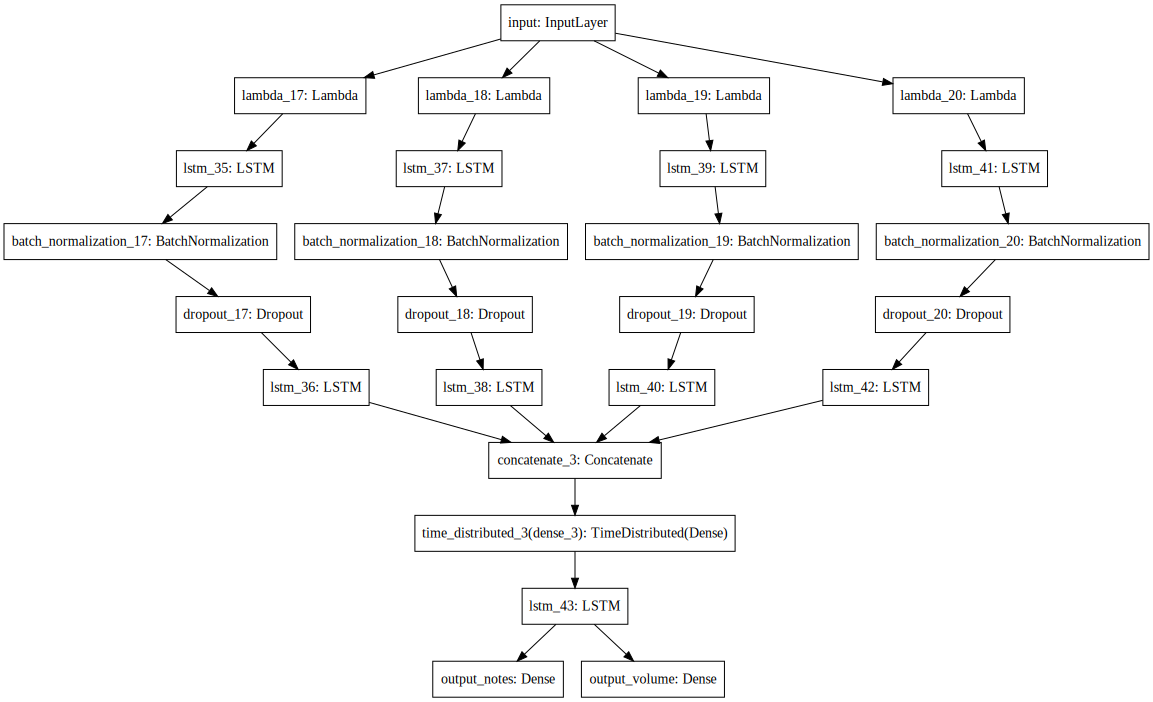

In [35]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [36]:
history = model.fit(
            {'input': train_X},
            {
                'output_notes': train_y_notes, 
                'output_volume': train_y_volume, 
#                 'output_length': train_y_length
            },
            validation_data=({'input': test_X},
                             {
                                 'output_notes': test_y_notes, 
                                 'output_volume': test_y_volume, 
#                                  'output_length': test_y_length
                             }), 
            verbose=1,
            shuffle=False,
            epochs=epochs, 
            batch_size=batch_size)

Train on 1000 samples, validate on 469 samples
Epoch 1/100
1000/1000 [==============================] - 15s - loss: 0.6628 - output_notes_loss: 0.3128 - output_volume_loss: 0.3500 - val_loss: 0.6874 - val_output_notes_loss: 0.2622 - val_output_volume_loss: 0.4253
Epoch 2/100
1000/1000 [==============================] - 11s - loss: 0.6351 - output_notes_loss: 0.3066 - output_volume_loss: 0.3286 - val_loss: 0.6831 - val_output_notes_loss: 0.2622 - val_output_volume_loss: 0.4209
Epoch 3/100
1000/1000 [==============================] - 11s - loss: 0.6119 - output_notes_loss: 0.3029 - output_volume_loss: 0.3090 - val_loss: 0.6783 - val_output_notes_loss: 0.2622 - val_output_volume_loss: 0.4160
Epoch 4/100
1000/1000 [==============================] - 11s - loss: 0.5889 - output_notes_loss: 0.2993 - output_volume_loss: 0.2896 - val_loss: 0.6733 - val_output_notes_loss: 0.2624 - val_output_volume_loss: 0.4109
Epoch 5/100
1000/1000 [==============================] - 11s - loss: 0.5749 - output_

1000/1000 [==============================] - 12s - loss: 0.4408 - output_notes_loss: 0.2246 - output_volume_loss: 0.2162 - val_loss: 0.7280 - val_output_notes_loss: 0.2889 - val_output_volume_loss: 0.4391
Epoch 39/100
1000/1000 [==============================] - 13s - loss: 0.4364 - output_notes_loss: 0.2248 - output_volume_loss: 0.2115 - val_loss: 0.7232 - val_output_notes_loss: 0.2896 - val_output_volume_loss: 0.4337
Epoch 40/100
1000/1000 [==============================] - 11s - loss: 0.4379 - output_notes_loss: 0.2255 - output_volume_loss: 0.2124 - val_loss: 0.7313 - val_output_notes_loss: 0.2911 - val_output_volume_loss: 0.4402
Epoch 41/100
1000/1000 [==============================] - 13s - loss: 0.4330 - output_notes_loss: 0.2235 - output_volume_loss: 0.2095 - val_loss: 0.7252 - val_output_notes_loss: 0.2920 - val_output_volume_loss: 0.4332
Epoch 42/100
1000/1000 [==============================] - 11s - loss: 0.4265 - output_notes_loss: 0.2199 - output_volume_loss: 0.2066 - val_l

1000/1000 [==============================] - 12s - loss: 0.3259 - output_notes_loss: 0.1731 - output_volume_loss: 0.1528 - val_loss: 0.7614 - val_output_notes_loss: 0.3302 - val_output_volume_loss: 0.4313
Epoch 76/100
1000/1000 [==============================] - 13s - loss: 0.3257 - output_notes_loss: 0.1729 - output_volume_loss: 0.1528 - val_loss: 0.7555 - val_output_notes_loss: 0.3267 - val_output_volume_loss: 0.4287
Epoch 77/100
1000/1000 [==============================] - 12s - loss: 0.3216 - output_notes_loss: 0.1692 - output_volume_loss: 0.1524 - val_loss: 0.7540 - val_output_notes_loss: 0.3296 - val_output_volume_loss: 0.4244
Epoch 78/100
1000/1000 [==============================] - 12s - loss: 0.3199 - output_notes_loss: 0.1678 - output_volume_loss: 0.1521 - val_loss: 0.7552 - val_output_notes_loss: 0.3278 - val_output_volume_loss: 0.4275
Epoch 79/100
1000/1000 [==============================] - 12s - loss: 0.3133 - output_notes_loss: 0.1669 - output_volume_loss: 0.1464 - val_l

In [39]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


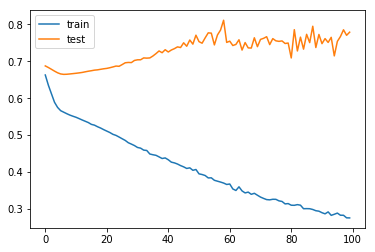

In [40]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

###### 